In [1]:
import random
import numpy as np
import pandas as pd
import IPython.core.display as di
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor


In [2]:
random.seed(9001)
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [3]:
def importdataset(path):
    df = pd.read_csv(path)
    df1 = df.dropna()
    print ("size of dataset  :", df.shape[0])
    print ("size of features :", df.shape[1])
    print ("size of NaN      :", df.shape[0] - df1.shape[0])
    return df

In [4]:
df = importdataset("train_clean.csv")
df.head()

size of dataset  : 2756003
size of features : 10
size of NaN      : 0


,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,number,label
0,1,1,6570,0,2,14.6000,16.8900,0.0000,0.0000,0
1,2,1,14922,1,1,8.5700,8.7500,0.0000,0.0000,1
2,3,1,16382,0,1,14.7700,16.0600,0.0000,0.0000,1
3,4,1,1145,1,1,6.5900,6.5500,6.5500,1.0000,2
4,5,1,3394,0,1,4.3900,4.1400,4.1400,1.0000,2


In [5]:
item = importdataset("items_clean.csv")
item.head()

size of dataset  : 22035
size of features : 10
size of NaN      : 0


,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp
0,1,1,529,80.0000,7,135,0,40,3.0000,10.8900
1,2,1,529,80.0000,7,135,0,40,3.0000,10.8900
2,3,1,529,10.0000,1,45,0,40,3.0000,16.4500
3,4,1,529,80.0000,7,135,0,40,3.0000,10.8900
4,5,2,74,8.0000,7,112,0,40,1.0000,22.5300


In [6]:
df = pd.merge(df, item, how='inner', on=['pid']).sort_values(['lineID'], ascending = True).reset_index(drop = True)

train = df[(df.day <= 62)].sort_values(['lineID'], ascending = True).reset_index(drop = True)
test = df[(df.day > 62)].sort_values(['lineID'], ascending = True).reset_index(drop = True)

print('Number of train : %d' % train.shape[0])
print('Number of test  : %d' % test.shape[0])
df.head()

Number of train : 1782748
Number of test  : 973255


,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,number,label,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp
0,1,1,6570,0,2,14.6000,16.8900,0.0000,0.0000,0,255,529,50.0000,5,147,0,40,193.0000,18.2500
1,2,1,14922,1,1,8.5700,8.7500,0.0000,0.0000,1,18,373,50.0000,7,135,1,40,66.0000,18.8100
2,3,1,16382,0,1,14.7700,16.0600,0.0000,0.0000,1,41,503,100.0000,5,130,0,53,40.0000,18.4800
3,4,1,1145,1,1,6.5900,6.5500,6.5500,1.0000,2,52,308,60.0000,1,44,0,40,25.0000,9.3100
4,5,1,3394,0,1,4.3900,4.1400,4.1400,1.0000,2,90,458,50.0000,7,75,0,53,14.0000,8.1300


In [7]:
col = ['adFlag','availability','competitorPrice','price','manufacturer','group','content','unit',
       'pharmForm','genericProduct','salesIndex','category','rrp']
X = train[col]
y = train[["label"]]

X_train = X.iloc[:int(X.shape[0]*0.8), :]
X_val = X.iloc[int(X.shape[0]*0.8):, :]
y_train = y.iloc[:int(y.shape[0]*0.8), :]
y_val = y.iloc[int(y.shape[0]*0.8):, :]

cw0 = y.label.value_counts()[0]/y.shape[0]
cw1 = y.label.value_counts()[1]/y.shape[0]
cw2 = y.label.value_counts()[2]/y.shape[0]

print ("size of training features :", X_train.shape[1])
print ("size of training          :", X_train.shape[0])
print ("size of validation        :", X_val.shape[0])
print ("=== Distribution of label in validation ===")
print ("class weight of label_0 :", cw0)
print ("class weight of label_1 :", cw1)
print ("class weight of label_1 :", cw2)


size of training features : 13
size of training          : 1426198
size of validation        : 356550
=== Distribution of label in validation ===
class weight of label_0 : 0.562037371519
class weight of label_1 : 0.17458496658
class weight of label_1 : 0.263377661902


In [8]:
def processing(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val).reshape(y_val.shape[0], 1)
    
    print('Misclassified samples: %d' % (y_val != y_pred).sum())
    print('Accuracy          : %.4f' % ((y_val == y_pred).sum() / y_val.shape[0]))
    print('Accuracy (sklearn): %.4f' % accuracy_score(y_val, y_pred))
    print("========== confusion matrix ==========")
    print(confusion_matrix(y_val, y_pred, labels = [0,1,2], sample_weight = None))
    return y_pred

def processing_reg(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_val) 
    score = np.dot((pred - y_val).T, (pred - y_val))  
    print("Euclidean Distance :", score)  
    df = pd.concat([pd.DataFrame(pred, columns=["pred"]), pd.DataFrame(y_val, columns=["val"])], axis=1)

    fig, ax = plt.subplots(figsize=(15, 6))
    df.plot.scatter(x='val', y='pred', ax = ax,
                    title = "scatter of test and prediction",
                    s = 30, alpha = 0.4)
    plt.show()
    return df


In [9]:
tree = DecisionTreeClassifier(criterion = 'entropy', 
                              max_depth = 5, 
                              random_state = 9001,
                              class_weight = {0:cw0, 1:cw1, 2:cw2})
pred_tree = processing(tree)

Misclassified samples: 122174
Accuracy          : 0.6573
Accuracy (sklearn): 0.6573
========== confusion matrix ==========
[[227300    213    490]
 [ 43808   5973    597]
 [ 76965    101   1103]]


### regresion (mse)

In [10]:
col = ['adFlag','availability','competitorPrice','price','manufacturer','group','content','unit',
       'pharmForm','genericProduct','salesIndex','category','rrp']
X = train[col]
y = train[["number"]]

X_train = X.iloc[:int(X.shape[0]*0.8), :]
X_val = X.iloc[int(X.shape[0]*0.8):, :]
y_train = np.array(y.iloc[:int(y.shape[0]*0.8), :]).reshape(X_train.shape[0], )
y_val = np.array(y.iloc[int(y.shape[0]*0.8):, :]).reshape(X_val.shape[0], )

print ("size of training features :", X_train.shape[1])
print ("size of training          :", X_train.shape[0])
print ("size of validation        :", X_val.shape[0])
print (y.number.describe())

size of training features : 13
size of training          : 1426198
size of validation        : 356550
count   1782748.0000
mean          0.3611
std           1.0179
min           0.0000
25%           0.0000
50%           0.0000
75%           1.0000
max         306.0000
Name: number, dtype: float64


Euclidean Distance : 333974.0


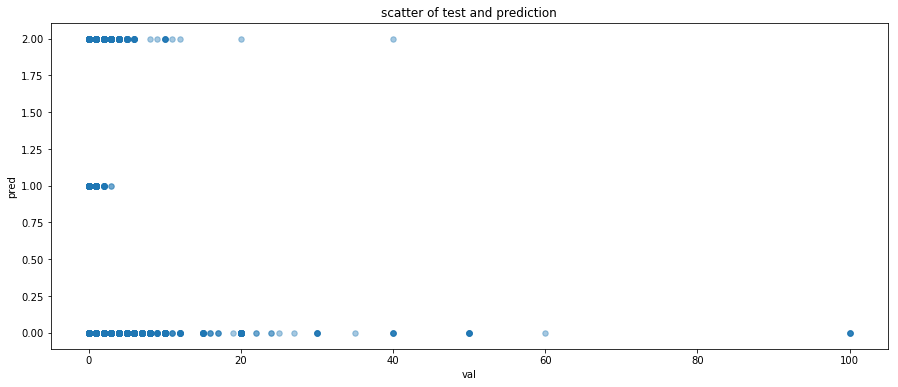

In [11]:
pred_tree = pred_tree.reshape(pred_tree.shape[0], )
score = np.dot((pred_tree - y_val).T, (pred_tree - y_val))  
print("Euclidean Distance :", score)  
df = pd.concat([pd.DataFrame(pred_tree, columns=["pred"]), pd.DataFrame(y_val, columns=["val"])], axis=1)

fig, ax = plt.subplots(figsize=(15, 6))
df.plot.scatter(x='val', y='pred', ax = ax,
                title = "scatter of test and prediction",
                s = 30, alpha = 0.4)
plt.show()


In [12]:
rfr = RandomForestRegressor(n_estimators             = 10, 
                            max_features             = 'log2', 
                            criterion                = 'mse', 
                            max_depth                = None, 
                            min_samples_split        = 20, 
                            min_samples_leaf         = 10, 
                            min_weight_fraction_leaf = 0.0, 
                            max_leaf_nodes           = None, 
                            min_impurity_split       = 1e-07, 
                            bootstrap                = True, 
                            oob_score                = False, 
                            n_jobs                   = 1, 
                            random_state             = 9001, 
                            verbose                  = 0, 
                            warm_start               = False)


Euclidean Distance : 272382.895334


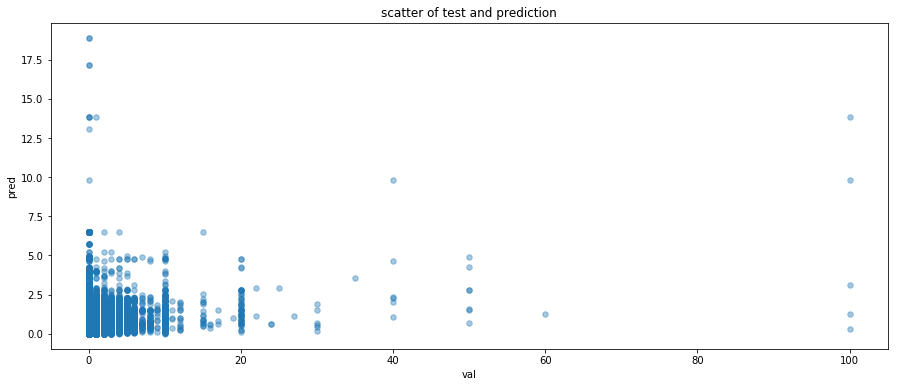

In [13]:
pred_rfr = processing_reg(rfr)